In [26]:
import plotnine
from plotnine import *
from m_kipoi.config import get_data_dir, setup_matplotlib
import json
from m_kipoi.exp.tlearn.tfdragonn import parse_log
from pathlib import Path
from snakemake.io import glob_wildcards
import pandas as pd
ddir = get_data_dir()
setup_matplotlib()

In [27]:
def load_results(glob_str=f"{ddir}/processed/tlearn/models/transferred/{{task}}/eval/valid/epoch-{{epoch}}.metrics.json"):
    def read_result(task, epoch, glob_str):
        fname = glob_str.format(task=task, epoch=epoch)
        return {"task": task, "epoch": int(epoch)+1, 
                **json.loads(Path(fname).read_text())}
    tasks, epochs,  = glob_wildcards(glob_str)
    return pd.DataFrame([read_result(task, epoch, glob_str) for task, epoch in zip(tasks, epochs)]).sort_values(['task', 'epoch'])

In [28]:
# Annotation
anno = pd.read_csv(f"{ddir}/raw/tlearn/metadata/anno.csv")

In [29]:
anno.head()

,task,Cell_Type
0,ENCSR000EMT,GM12878
1,ENCSR000EPC,K562
2,ENCSR452SPC,Brain
3,ENCSR714DIF,Mesendoderm
4,ENCSR917VCP,Thymus


In [30]:
encode_ids = anno.task.tolist()

## Test-set

In [31]:
# Pre-trained 
dftn = load_results(f"{ddir}/processed/tlearn/models/transferred/{{task}}/eval/test/epoch-{{epoch}}.metrics.json").rename(columns={"auprc": "auPRC"})

In [32]:
dftn

,accuracy,auc,auPRC,epoch,task
7,0.953866,0.856024,0.406399,13,ENCSR000EMT
9,0.970945,0.907713,0.478978,4,ENCSR000EMX
1,0.950570,0.877829,0.477016,2,ENCSR000EOS
4,0.938530,0.792407,0.370149,2,ENCSR000EPC
3,0.911958,0.833294,0.475205,2,ENCSR076YBB;ENCSR456KDF;ENCSR482HQE;ENCSR930AUG
2,0.940847,0.868478,0.505002,2,ENCSR122VUW;ENCSR191EII;ENCSR320TUJ;ENCSR468ZX...
5,0.935301,0.885296,0.544269,5,ENCSR452SPC
6,0.938154,0.827797,0.417237,5,ENCSR714DIF
0,0.922339,0.856137,0.481662,2,ENCSR731QLJ
8,0.954748,0.889586,0.466559,7,ENCSR917VCP


In [33]:
dfto = pd.concat([parse_log(f"{ddir}/processed/tlearn/models/random/test/{encode_id}/tfdragonn.log").assign(task=encode_id) 
                  for encode_id in encode_ids])

/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/exp/tlearn/tfdragonn.py:62: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  ("weights_file", weights_file),
/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/exp/tlearn/tfdragonn.py:65: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  dfo['best_epoch'] = dfo.iloc[dfo.auPRC.argmax()].epoch


In [34]:
# Merge Pre-trained + Random
dft = pd.concat([dftn[['auPRC', 'task']].merge(anno, on='task').assign(Model="Pre-trained"),
                 dfto.merge(anno, on='task')[['task', 'Cell_Type', 'auPRC']].assign(Model='Random')], sort=True)

In [35]:
dft

,Cell_Type,Model,auPRC,task
0,GM12878,Pre-trained,0.406399,ENCSR000EMT
1,Cardiac Mesendoderm,Pre-trained,0.478978,ENCSR000EMX
2,Jakart Clone E61,Pre-trained,0.477016,ENCSR000EOS
3,K562,Pre-trained,0.370149,ENCSR000EPC
4,Lung,Pre-trained,0.475205,ENCSR076YBB;ENCSR456KDF;ENCSR482HQE;ENCSR930AUG
5,Common myeloid progenitor,Pre-trained,0.505002,ENCSR122VUW;ENCSR191EII;ENCSR320TUJ;ENCSR468ZX...
6,Brain,Pre-trained,0.544269,ENCSR452SPC
7,Mesendoderm,Pre-trained,0.417237,ENCSR714DIF
8,Mesenchymal Stem Cell,Pre-trained,0.481662,ENCSR731QLJ
9,Thymus,Pre-trained,0.466559,ENCSR917VCP


In [36]:
# Organize
dft['Cell_Type_cat'] = pd.Categorical(dft['Cell_Type'], categories=dft.sort_values("Cell_Type", ascending=True).Cell_Type.unique(), ordered=True)
dft['Model'] = pd.Categorical(dft['Model'], categories=['Random', 'Pre-trained'], ordered=True)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplica

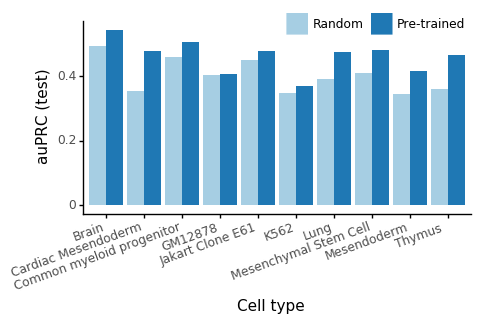

<ggplot: (-9223363302171508606)>

In [37]:
plotnine.options.figure_size = (5,2.5)
gplt = ggplot(aes(x='Cell_Type', y='auPRC', fill='Model'), data=dft) + \
    theme_classic() + \
    theme(axis_text_x=element_text(angle=20, hjust = 1)) + \
    theme(legend_title=element_blank(), 
          legend_box_margin=0,
          legend_direction='horizontal', legend_position=(0.71,0.87)) + \
    geom_bar(stat='identity', position="dodge") + \
    scale_fill_brewer("qual", 3) + \
    xlab("Cell type") + \
    ylab("auPRC (test)")
gplt

In [38]:
gplt.save("plots/fig3b.pdf", dpi=600)
gplt.save("plots/fig3b.png", dpi=600)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 5 x 2.5 in image.
  from_inches(height, units), units))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: plots/fig3b.pdf
  warn('Filename: {}'.format(filename))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: A

## Validation

In [39]:
# Pre-trained
dfvn = load_results(f"{ddir}/processed/tlearn/models/transferred/{{task}}/eval/valid/epoch-{{epoch}}.metrics.json").rename(columns={"auprc": "auPRC"})
dfvn = dfvn.merge((dfvn.groupby("task").epoch.max()-1).reset_index().rename(columns={"epoch": "best_epoch"}), on="task", how="left")

In [40]:
dfvo = pd.concat([parse_log(f"{ddir}/processed/tlearn/models/random/valid/{encode_id}/tfdragonn.log").assign(task=encode_id) 
                  for encode_id in encode_ids])

/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/exp/tlearn/tfdragonn.py:62: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  ("weights_file", weights_file),
/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/exp/tlearn/tfdragonn.py:65: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  dfo['best_epoch'] = dfo.iloc[dfo.auPRC.argmax()].epoch


In [41]:
# Merge pre-trained + random
dfv = pd.concat([dfvn[['auPRC', 'epoch', 'best_epoch', 'task']].merge(anno, on='task').assign(Model='Pre-trained'),
                 dfvo.merge(anno, on='task')[['auPRC', 'epoch', 'best_epoch', 'task', "Cell_Type"]].assign(Model='Random')])

In [42]:
# Organize
dfv['Model'] = pd.Categorical(dfv['Model'], categories=['Random', 'Pre-trained'], ordered=True)
dfv_best_epoch = dfv[['Model', 'Cell_Type', 'best_epoch']].drop_duplicates()

In [43]:
dfv[(dfv.Model=='Pre-trained') & (dfv.Cell_Type == 'Brain')]

,auPRC,epoch,best_epoch,task,Cell_Type,Model
31,0.531692,1,5,ENCSR452SPC,Brain,Pre-trained
32,0.532634,2,5,ENCSR452SPC,Brain,Pre-trained
33,0.532571,3,5,ENCSR452SPC,Brain,Pre-trained
34,0.533176,4,5,ENCSR452SPC,Brain,Pre-trained
35,0.533446,5,5,ENCSR452SPC,Brain,Pre-trained
36,0.532688,6,5,ENCSR452SPC,Brain,Pre-trained


/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


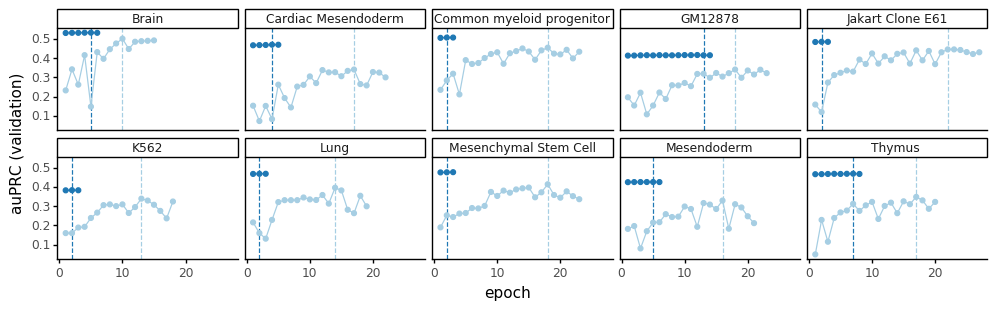

<ggplot: (-9223363302292846087)>

In [44]:
plotnine.options.figure_size = (12,3)
plt = ggplot(aes(x='epoch', y='auPRC', group='Model', color='Model'), data=dfv) + \
    geom_vline(aes(xintercept="best_epoch", color='Model'), dfv_best_epoch, linetype='dashed', alpha=1) + \
    geom_line() + \
    geom_point() + \
    facet_wrap('~Cell_Type', nrow=2) + \
    theme_classic() + \
    scale_color_brewer("qual", 3) + \
    theme(legend_position=(0.8, 0.3)) + \
    ylab("auPRC (validation)")
plt

In [46]:
dfv

,auPRC,epoch,best_epoch,task,Cell_Type,Model
0,0.413587,1,13,ENCSR000EMT,GM12878,Pre-trained
1,0.413988,2,13,ENCSR000EMT,GM12878,Pre-trained
2,0.415082,3,13,ENCSR000EMT,GM12878,Pre-trained
3,0.415821,4,13,ENCSR000EMT,GM12878,Pre-trained
4,0.414696,5,13,ENCSR000EMT,GM12878,Pre-trained
5,0.416121,6,13,ENCSR000EMT,GM12878,Pre-trained
6,0.415328,7,13,ENCSR000EMT,GM12878,Pre-trained
7,0.415069,8,13,ENCSR000EMT,GM12878,Pre-trained
8,0.415658,9,13,ENCSR000EMT,GM12878,Pre-trained
9,0.416468,10,13,ENCSR000EMT,GM12878,Pre-trained


In [47]:
dfv_total_epoch_stacked = dfv[['Cell_Type', 'Model']].groupby(['Cell_Type', 'Model']).size().unstack()
dfv_total_epoch_stacked.columns = ['Random', 'Pre-trained']
dfv_total_epoch_stacked['speedup'] = dfv_total_epoch_stacked['Random']/dfv_total_epoch_stacked['Pre-trained'] 
print(dfv_total_epoch_stacked.to_string())

                           Random  Pre-trained   speedup
Cell_Type                                               
Brain                          15            6  2.500000
Cardiac Mesendoderm            22            5  4.400000
Common myeloid progenitor      23            3  7.666667
GM12878                        23           14  1.642857
Jakart Clone E61               27            3  9.000000
K562                           18            3  6.000000
Lung                           19            3  6.333333
Mesenchymal Stem Cell          23            3  7.666667
Mesendoderm                    21            6  3.500000
Thymus                         20            8  2.500000


In [48]:
dfv_total_epoch_stacked.describe().head(2)

,Random,Pre-trained,speedup
count,10.0,10.0,10.000000
mean,21.1,5.4,5.120952


In [49]:
dfv_best_epoch_stacked = dfv_best_epoch.set_index(['Cell_Type', 'Model']).best_epoch.unstack()
dfv_best_epoch_stacked.columns = ['Random', 'Pre-trained']
dfv_best_epoch_stacked['speedup'] = dfv_best_epoch_stacked['Random']/dfv_best_epoch_stacked['Pre-trained'] 
print(dfv_best_epoch_stacked.to_string())

                           Random  Pre-trained    speedup
Cell_Type                                                
Brain                          10            5   2.000000
Cardiac Mesendoderm            17            4   4.250000
Common myeloid progenitor      18            2   9.000000
GM12878                        18           13   1.384615
Jakart Clone E61               22            2  11.000000
K562                           13            2   6.500000
Lung                           14            2   7.000000
Mesenchymal Stem Cell          18            2   9.000000
Mesendoderm                    16            5   3.200000
Thymus                         17            7   2.428571


In [50]:
dfv_best_epoch_stacked.describe().head(2)

,Random,Pre-trained,speedup
count,10.0,10.0,10.000000
mean,16.3,4.4,5.576319


In [51]:
plt.save("plots/fig3c.pdf", dpi=600)
plt.save("plots/fig3c.png", dpi=600)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 12 x 3 in image.
  from_inches(height, units), units))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: plots/fig3c.pdf
  warn('Filename: {}'.format(filename))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: At